In [1]:
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import json


In [2]:
df = pd.read_csv("aaveExample.csv")

# Clean Up dates

df['FirstDeposit'] = df['FirstDeposit'].astype('datetime64[ns]')
df['LastWithdraw'] = df['LastWithdraw'].astype('datetime64[ns]')



In [3]:
df.head()

,Unnamed: 0,user,FirstDeposit,FirstBorrow,LastWithdraw,LastLiquidation,TotalUSDSupplied,TotalDepositsWETH,TotalWithdrawalsWETH,TotalLiquidationsWETH,...,TotalLiquidationsLUSD,TotalBorrowsLUSD,TotalRepaymentsLUSD,Total CollateralLUSD,Total Collateral USDLUSD,Total Collateral USD,End Date,TotalDaysSinceEntry,DaysUntilExit,Exit
0,0,0x1ad3b6b2df0046cef9bbbc3441790c3a600fd989,2021-03-30 05:57:28,2021-03-30 05:57:28,2021-06-12 09:30:28,NaN,509487.013270,114.90,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,164979.744755,2022-12-31 23:59:11,641,74.0,False
1,1,0x2c3e64f5077f5670caff4177fca1e182dedead3f,2022-08-25 02:31:15,2022-08-25 02:31:15,NaT,NaN,1.057695,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.780861,2022-12-31 23:59:11,128,NaN,False
2,2,0xa8b7a33f25490b8eebb10312e82403e8e9013663,2021-06-29 05:41:10,2021-06-29 05:41:10,NaT,NaN,42.350787,0.02,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.405800,2022-12-31 23:59:11,550,NaN,False
3,3,0x80d4ea495d4a02d84486c50bb197ba3bd3622859,2022-06-04 06:15:27,2022-06-04 06:15:27,2022-07-06 14:15:09,NaN,32435.890847,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-21.703572,2022-12-31 23:59:11,210,32.0,True
4,4,0x55d23b6a55ebac344a1a2e664e803a6880b46c83,2022-10-19 08:27:47,2022-10-19 08:27:47,2022-10-28 11:08:59,NaN,11.957777,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.355920,2022-12-31 23:59:11,73,9.0,False


In [4]:
# calc retention

# Filters - applied when calculating retention 
AssetDeposited = ['WETH']
minDepositValue = 10000


Days = range(500)
reducedDf = df[df['TotalUSDSupplied'] > minDepositValue]
retentionList = []

for day in Days :
    reducedDf = reducedDf[reducedDf['TotalDaysSinceEntry'] > day]
    n = len(reducedDf) 
    exits = (reducedDf[reducedDf.Exit == True])
    retention = 1 - sum(exits['DaysUntilExit'] < day) / len(reducedDf)
    retentionList.append(retention)

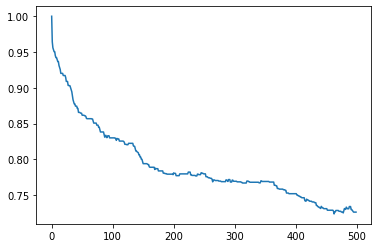

In [5]:
plt.plot(retentionList)

In [6]:
date = pd.Timestamp('2022-10-01')
# New Users 
minDepositValue = 100000

newUsers = list(df[(df['FirstDeposit'] > date) & (df['TotalUSDSupplied'] >= minDepositValue) & (df['Exit'] == False)]['user'])
lostUsers = list(df[(df['LastWithdraw'] > date) & (df['TotalUSDSupplied'] >= minDepositValue) & (df['Exit'] == True)]['user'])

In [7]:
"""

# get insights on users that have left & are new 
api_key = 'df73fafff72674634df8d995d3753c3c735dbb1b'
#insightUsers = newUsers + lostUsers

insightUsers = list(df['user'])

headers = {'AccessKey': api_key}
base_url = 'https://pro-openapi.debank.com/v1'
total_balance = {}

for user in insightUsers:
    url = f'{base_url}/user/all_complex_protocol_list?id={user}'
    #print(url)
    res = requests.get(url, headers=headers)
    data = res.json()
    total_balance[user] = data
    #print(json.dumps(data, indent=4))

with open('./data.json', 'w') as f:
    json.dump(total_balance, f)
    
    
n = len(insightUsers)

cleanData = []

for user in insightUsers : 
    user_data = total_balance[user]
    address = user
    items = len(user_data)
    for j in range(items) : 
        item = user_data[j]
        
        portfolioInfo = item['portfolio_item_list']
        pItems = len(portfolioInfo)
        value = 0
        for p in range(pItems) : 
            value += item['portfolio_item_list'][p]['stats']['net_usd_value']
            #asset = 
        appendItem = {
            "User" : address,
            "Name" : item['name'],
            "Chain" : item['chain'],
            "Value" : value
        }
        
        cleanData.append(appendItem)
        
        
userDf = pd.DataFrame(cleanData)
userDf.to_csv("AAVEusers.csv")

"""

'\n\n# get insights on users that have left & are new \napi_key = \'df73fafff72674634df8d995d3753c3c735dbb1b\'\n#insightUsers = newUsers + lostUsers\n\ninsightUsers = list(df[\'user\'])\n\nheaders = {\'AccessKey\': api_key}\nbase_url = \'https://pro-openapi.debank.com/v1\'\ntotal_balance = {}\n\nfor user in insightUsers:\n    url = f\'{base_url}/user/all_complex_protocol_list?id={user}\'\n    #print(url)\n    res = requests.get(url, headers=headers)\n    data = res.json()\n    total_balance[user] = data\n    #print(json.dumps(data, indent=4))\n\nwith open(\'./data.json\', \'w\') as f:\n    json.dump(total_balance, f)\n    \n    \nn = len(insightUsers)\n\ncleanData = []\n\nfor user in insightUsers : \n    user_data = total_balance[user]\n    address = user\n    items = len(user_data)\n    for j in range(items) : \n        item = user_data[j]\n        \n        portfolioInfo = item[\'portfolio_item_list\']\n        pItems = len(portfolioInfo)\n        value = 0\n        for p in range(pI

In [8]:
userDf = pd.read_csv("AAVEusers.csv")

In [9]:
### New User Portfolios

userDf[userDf.User == newUsers[0]]

,Unnamed: 0,User,Name,Chain,Value
3243,3243,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,Aave V2,eth,1.613568e-15
3244,3244,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,Abracadabra,avax,4.183897e-01
3245,3245,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,BENQI,avax,4.229285e+00
3246,3246,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,Hashflow,avax,1.808000e+01
3247,3247,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,Trader Joe Lending,avax,7.459683e-01
3248,3248,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,Balancer V2,eth,1.603836e-06
3249,3249,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,Compound,eth,3.989416e-02
3250,3250,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,KyberSwap,eth,3.478991e+05
3251,3251,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,LIDO,eth,1.562355e-06
3252,3252,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,Aave V3,matic,3.711209e+05


In [10]:
### Lost User Portfolios

userDf[userDf.User == lostUsers[2]]

,Unnamed: 0,User,Name,Chain,Value
5226,5226,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,GrizzlyFi,bsc,920688.112760
5227,5227,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Venus,bsc,84016.050593
5228,5228,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Compound,eth,6.657349
5229,5229,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Damm Finance,eth,0.000000
5230,5230,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,DeFi Franc,eth,0.011439
5231,5231,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Geist,ftm,461379.629425


In [11]:
def totalTVL(row):
    return userDf[userDf.User == row['user']]['Value'].sum()

def totalTVLAAVE(row):
    return userDf[(userDf.User == row['user']) & (userDf.Name == 'Aave V2')]['Value'].sum()

In [12]:
df['totalTVL'] = df.apply(totalTVL, axis=1)
df['totalTVLAAVE'] = df.apply(totalTVLAAVE, axis=1)

df['Percent In AAVE'] = df['totalTVLAAVE'] / df['totalTVL']

In [13]:
# Filters - applied when running analysis retention 
minTVL = 10000

reducedDf = df[df['totalTVL'] > minTVL]



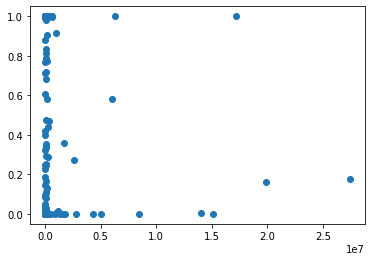

In [14]:
plt.scatter(reducedDf['totalTVL'], reducedDf['Percent In AAVE'])

(array([89.,  8.,  7.,  6.,  4.,  2.,  2.,  5.,  3., 26.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

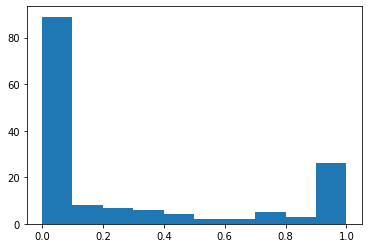

In [15]:
plt.hist(reducedDf['Percent In AAVE'])

In [16]:
otherApps = list(userDf['Name'].unique())

exclude = ['Aave V2', 'Aave V3']
for item in exclude : 
    otherApps.remove(item)

compDf = pd.DataFrame({'Name' : otherApps})

lostUserDf = userDf[userDf.User.isin(lostUsers)]


In [17]:
lostUserDf.nlargest(5, ['Value'])

,Unnamed: 0,User,Name,Chain,Value
5226,5226,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,GrizzlyFi,bsc,920688.112760
5231,5231,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Geist,ftm,461379.629425
5227,5227,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Venus,bsc,84016.050593
6992,6992,0x49ae763ed846db9a69a639732caa320fad1d5799,Convex,eth,12325.918568
6989,6989,0x49ae763ed846db9a69a639732caa320fad1d5799,Aave V3,avax,3369.748955


In [20]:
def compTVL(row):
    return userDf[userDf.Name == row['Name']]['Value'].sum()

def compUsers(row):
    return len(userDf[userDf.Name == row['Name']])

def tvlInAAVE(row):
    userList = list(userDf[userDf.Name == row['Name']]['User'])
    return userDf[(userDf.User.isin(userList)) & (userDf.Name.isin(exclude))]['Value'].sum()

def lostTVL(row): 
    userList = list(lostUserDf[lostUserDf.Name == row['Name']]['User'])
    return df[(df.user.isin(userList))]['TotalUSDSupplied'].sum()
    
def compTVLGained(row):    
    return lostUserDf[lostUserDf.Name == row['Name']]['Value'].sum()
    
def lostUsers(row):
    return len(lostUserDf[lostUserDf.Name == row['Name']])
    
    
compDf['TVLFromSharedUsers'] =  compDf.apply(compTVL, axis=1)      
compDf['nUsers'] =  compDf.apply(compUsers, axis=1)      
compDf['tvlInAAVE'] = compDf.apply(tvlInAAVE, axis=1) 

compDf['lostTVL'] =  compDf.apply(lostTVL, axis=1) 
compDf['compTVLGained'] =  compDf.apply(compTVLGained, axis=1) 
compDf['lostUsers'] =  compDf.apply(lostUsers, axis=1) 

In [21]:
# Of competitors what are N largest protocols that users are using (by TVL)
compDf.nlargest(5,['TVLFromSharedUsers'])

,Name,TVLFromSharedUsers,nUsers,tvlInAAVE,lostTVL,compTVLGained,lostUsers
54,Convex,3.420833e+07,59,9.138560e+06,9.364006e+06,1.232592e+04,1
71,Curve,1.572565e+07,318,8.977048e+06,0.000000e+00,0.000000e+00,0
8,LIDO,1.145023e+07,293,1.674522e+07,1.013677e+07,3.231160e-15,2
11,Uniswap V3,9.639009e+06,432,8.649448e+06,0.000000e+00,0.000000e+00,0
74,Uniswap V2,6.114480e+06,49,8.818016e+06,6.652763e+05,4.129660e+00,1


In [19]:
# where have lost users gone ??? 

compDf

,Name
0,GMX
1,Wonderland
2,Venus
3,Adamant
4,Klima DAO
...,...
548,Voltage
549,Unifi Protocol
550,Dot Dot Finance
551,Valas
